In [1]:
# using version 1.8.0 of scikit-learn
# this cell just contains necessary imports for this example
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage, sparse
from sklearn.linear_model import Lasso, Ridge

In [2]:
# some helper functions to streamline further code

def _weights(x, dx=1, orig=0): # sets up interpolation weights for estimating pixel values
    x = np.ravel(x)
    floor_x = np.floor((x-orig)/dx).astype(np.int64)
    alpha = (x - orig - floor_x*dx)/dx
    return np.hstack((floor_x, floor_x+1)), np.hstack((1-alpha, alpha))

def _generate_center_coordinates(l_x): # sets up coordinate grid with dimensions l_x by l_x
    X, Y = np.mgrid[:l_x,:l_x].astype(np.float64)
    center = l_x/2.0
    X += 0.5-center
    Y += 0.5-center
    return X, Y

In [3]:
# function that creates the tomography matrix
def build_projection_operator(l_x, n_dir):
    X, Y = _generate_center_coordinates(l_x)
    angles = np.linspace(0, np.pi, n_dir, endpoint=False)
    data_inds, weights, camera_inds = [], [], []
    data_unravel_indices = np.arange(l_x**2)
    data_unravel_indices = np.hstack((data_unravel_indices, data_unravel_indices))

    for i, angle in enumerate(angles): # rotates image coordinates to store multiple angles of image
        Xrot = np.cos(angle)*X - np.sin(angle)*Y
        inds, w = _weights(Xrot, dx=1, orig=X.min())
        mask = np.logical_and(inds>=0, inds<l_x)
        weights += list(w[mask])
        camera_inds += list(inds[mask] + i*l_x)
        data_inds += list(data_unravel_indices[mask])

    proj_operator = sparse.coo_matrix((weights, (camera_inds, data_inds))) # generate sparse matrix of image
    return proj_operator

In [4]:
# function to create synthetic image (for demo purposes, could be used with actual imported images)
def generate_synthetic_data():
    rs = np.random.RandomState(0) # setting a random state for consistency
    n_pts = 36
    x, y = np.ogrid[0:l, 0:l] # l is a global variable that sets the size of the image that will be produced
    mask_outer = (x-l/2.0)**2 + (y-l/2.0)**2 < (l/2.0)**2
    mask = np.zeros((l, l))
    points = l * rs.rand(2, n_pts)
    mask[(points[0]).astype(int), (points[1]).astype(int)] = 1
    mask = ndimage.gaussian_filter(mask, sigma=l/n_pts)
    res = np.logical_and(mask>mask.mean(), mask_outer)
    return np.logical_xor(res, ndimage.binary_erosion(res))

In [5]:
# generating images and projections
l=128
proj_operator = build_projection_operator(l, l//7)
data = generate_synthetic_data()
proj = proj_operator @ data.ravel()[:, np.newaxis]
proj += 0.15*np.random.randn(*proj.shape) # adding synthesized noise to image

In [6]:
# reconstruction using Ridge penalization
rgr_ridge = Ridge(alpha=0.2)
rgr_ridge.fit(proj_operator, proj.ravel())
rec_l2 = rgr_ridge.coef_.reshape(l,l)

In [7]:
# reconstruction under Lasso penalization
rgr_lasso = Lasso(alpha=0.001)
rgr_lasso.fit(proj_operator, proj.ravel())
rec_l1 = rgr_lasso.coef_.reshape(l,l)

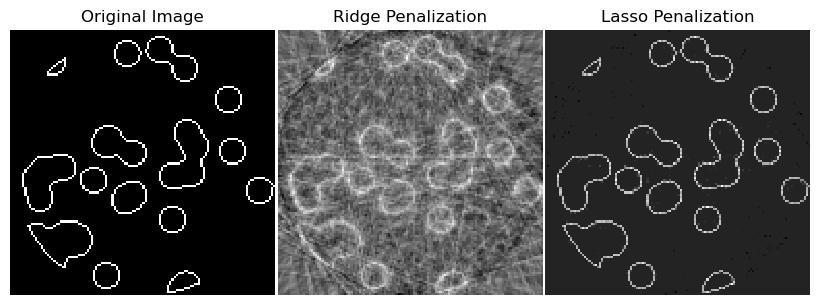

In [8]:
# producing image outputs with plt
plt.figure(figsize=(8,3.3))
plt.subplot(131)
plt.imshow(data, cmap=plt.cm.gray, interpolation='nearest')
plt.axis('off')
plt.title('Original Image')
plt.subplot(132)
plt.imshow(rec_l2, cmap=plt.cm.gray, interpolation='nearest')
plt.title('Ridge Penalization')
plt.axis('off')
plt.subplot(133)
plt.imshow(rec_l1, cmap=plt.cm.gray, interpolation='nearest')
plt.title('Lasso Penalization')
plt.axis('off')

plt.subplots_adjust(hspace=0.01,wspace=0.01, top=1, bottom=0, left=0, right=1)

plt.show()

In [9]:
# From the images above, it can be seen that Lasso penalization was more accurate to the original image than Ridge penalization.
# While Ridge produced a lot more artifacting, Lasso only had some pixel artifacts. This is due to the original image being a sparse image,
# meaning that it only had a pixel value of either 0 or 1, making Lasso more efficient in this case. This comes down to the difference in 
# each approach, where Lasso forces pixels to go completely to a value of 0 while Ridge approximates them. If the image had more features,
# then Ridge would be better for reconstruction as it would keep more features from the original image that Lasso would just ignore.